In [3]:
# --- IMPORTS ---
import numpy as np
import stackstac
import pystac_client
import planetary_computer
import dask.array as da
from dask.distributed import Client, LocalCluster
from urllib3.util.retry import Retry
from dask.diagnostics import ProgressBar
import xarray as xr
import matplotlib.pyplot as plt
import ipyleaflet


# --- PARAMETERS ---
# Choose how to group the time dimension: "month", "week", or "year"
time_grouping = "month"  # Options: "month", "week", "year"
spatial_resolution = 50  # Spatial resolution in meters
bands_to_load = ['B02', 'B03', 'B04', 'SCL']  # Blue, Green, Red, Scene Classification
local_cluster = False  # Set to False if using Coiled

In [2]:

# --- DASK CLUSTER SETUP ---
if local_cluster:
    cluster = LocalCluster()
    client = Client(cluster)
else:
    import coiled
    cluster = coiled.Cluster(name="Timelapse", shutdown_on_close=True)
    cluster.adapt(n_workers=1, maximum=8)
    client = cluster.get_client()


[2025-06-19 14:15:53,187][INFO    ][coiled] Using existing cluster: 'Timelapse (id: 953601)'
[2025-06-19 14:15:53,187][INFO    ][coiled] Attaching to existing cluster (name: Timelapse, https://cloud.coiled.io/clusters/953601 )
2025-06-19 14:15:58,243 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=1 maximum=8


In [4]:

# --- MAP FOR BOUNDING BOX SELECTION ---
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = (41.64933994767867, -69.94438630063088)
m.zoom = 12
m.layout.height = "500px"
m.layout.width = "500px"
display(m)


Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [5]:

# Wait for user to select area, then get bounding box
# (You may want to add a widget for interactive selection in a real workflow)
bounding_box = (m.west, m.south, m.east, m.north)


In [6]:

# --- LOAD DATA FROM PLANETARY COMPUTER ---
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bounding_box,
    datetime="2024-01-01/2024-12-31"
)
items = search.item_collection()
print(f"Found {len(items)} items in the selected area and time range.")


Found 521 items in the selected area and time range.


In [7]:

# Stack the data using stackstac
data = stackstac.stack(
    items,
    assets=bands_to_load,
    resolution=spatial_resolution,
    epsg=3857,
    bounds_latlon=bounding_box,
)

print("Array size information:")
print(f"Shape: {data.shape}")
print(f"Size in bytes: {data.data.nbytes}")
print(f"Size in GB: {data.data.nbytes / 1e9:.2f} GB")
print(f"Number of chunks: {data.data.npartitions}")
print(f"Chunksize: {(data.data.nbytes / data.data.npartitions) / 1e6:.2f} MB")

data


Array size information:
Shape: (521, 4, 1530, 1530)
Size in bytes: 39027484800
Size in GB: 39.03 GB
Number of chunks: 8336
Chunksize: 4.68 MB


<xarray.DataArray 'stackstac-24aca4dafd83d4aa9b5d52c86c047d25' (time: 521,
                                                                band: 4,
                                                                y: 1530, x: 1530)> Size: 39GB
dask.array<fetch_raster_window, shape=(521, 4, 1530, 1530), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 4kB 2024-0...
    id                                       (time) <U54 113kB 'S2B_MSIL2A_20...
  * band                                     (band) <U3 48B 'B02' ... 'SCL'
  * x                                        (x) float64 12kB 3.786e+06 ... 3...
  * y                                        (y) float64 12kB 3.724e+06 ... 3...
    s2:processing_baseline                   (time) <U5 10kB '05.10' ... '05.11'
    ...                                       ...
    gsd                                      (band) float64 32B 10.0 ... 20.0
    title                                    (band) <U29 464B 'Band 2 - Blue ...
    common_name                              (band) object 32B 'blue' ... None
    center_wavelength                        (band) object 32B 0.49 ... None
    full_width_half_max                      (band) object 32B 0.098 ... None
    epsg                                     int32 4B 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(3786350, 3648000, 3862850, 372...
    crs:         epsg:3857
    transform:   | 50.00, 0.00, 3786350.00|\n| 0.00,-50.00, 3724500.00|\n| 0....
    resolution:  50

In [8]:
client.cluster.scale(6)
print("Scaled the cluster to 6 workers.")

# Establish SCL band on its own
scl_band = data.sel(band='SCL')

# Classes to discard (i.e clouds or defective pixels)
cloudy_classes = [3, 8, 9, 10, 11]

# Cloud mask, i.e where pixels are not cloudy
cloud_mask = scl_band.isin(cloudy_classes)

daily_cloud_mask_frac = cloud_mask.resample(time='1D').mean(dim='time', skipna = True)
daily_cloud_score = daily_cloud_mask_frac.mean(dim=["x", "y"]).compute()

grouping_accessor = getattr(daily_cloud_score.time.dt, time_grouping)

best_daily_timestamps = daily_cloud_score.groupby(grouping_accessor).map(lambda x: x.idxmin())
data_days = data.time.dt.floor('D')
mask_best_days = data_days.isin(best_daily_timestamps)

filtered_data = data.where(mask_best_days, drop=True)

scl_band = filtered_data.sel(band='SCL')
cloud_mask = scl_band.isin(cloudy_classes)
filtered_data = filtered_data.where(~cloud_mask)

rgb_composites = filtered_data.sel(band=['B02', 'B03', 'B04']).resample(time='1d').median(skipna=True, keep_attrs=True)
rgb_composites = rgb_composites.dropna(dim='time', how = 'all')

# Import geogif for creating animated GIFs from geospatial data
import geogif

geogif = geogif.dgif(rgb_composites, fps=4)
geogif.compute()

client.cluster.scale(1)

[2025-06-19 14:17:45,669][WARNING ][coiled] Turning off adaptive scaling because `scale(n=6)` was explicitly called.
To resume adaptive scaling, you can use the `adapt(minimum=..., maximum=...)` method.
2025-06-19 14:17:45,991 - distributed.deploy.adaptive - INFO - Adaptive scaling stopped: minimum=1 maximum=8. Reason: unknown


Scaled the cluster to 6 workers.


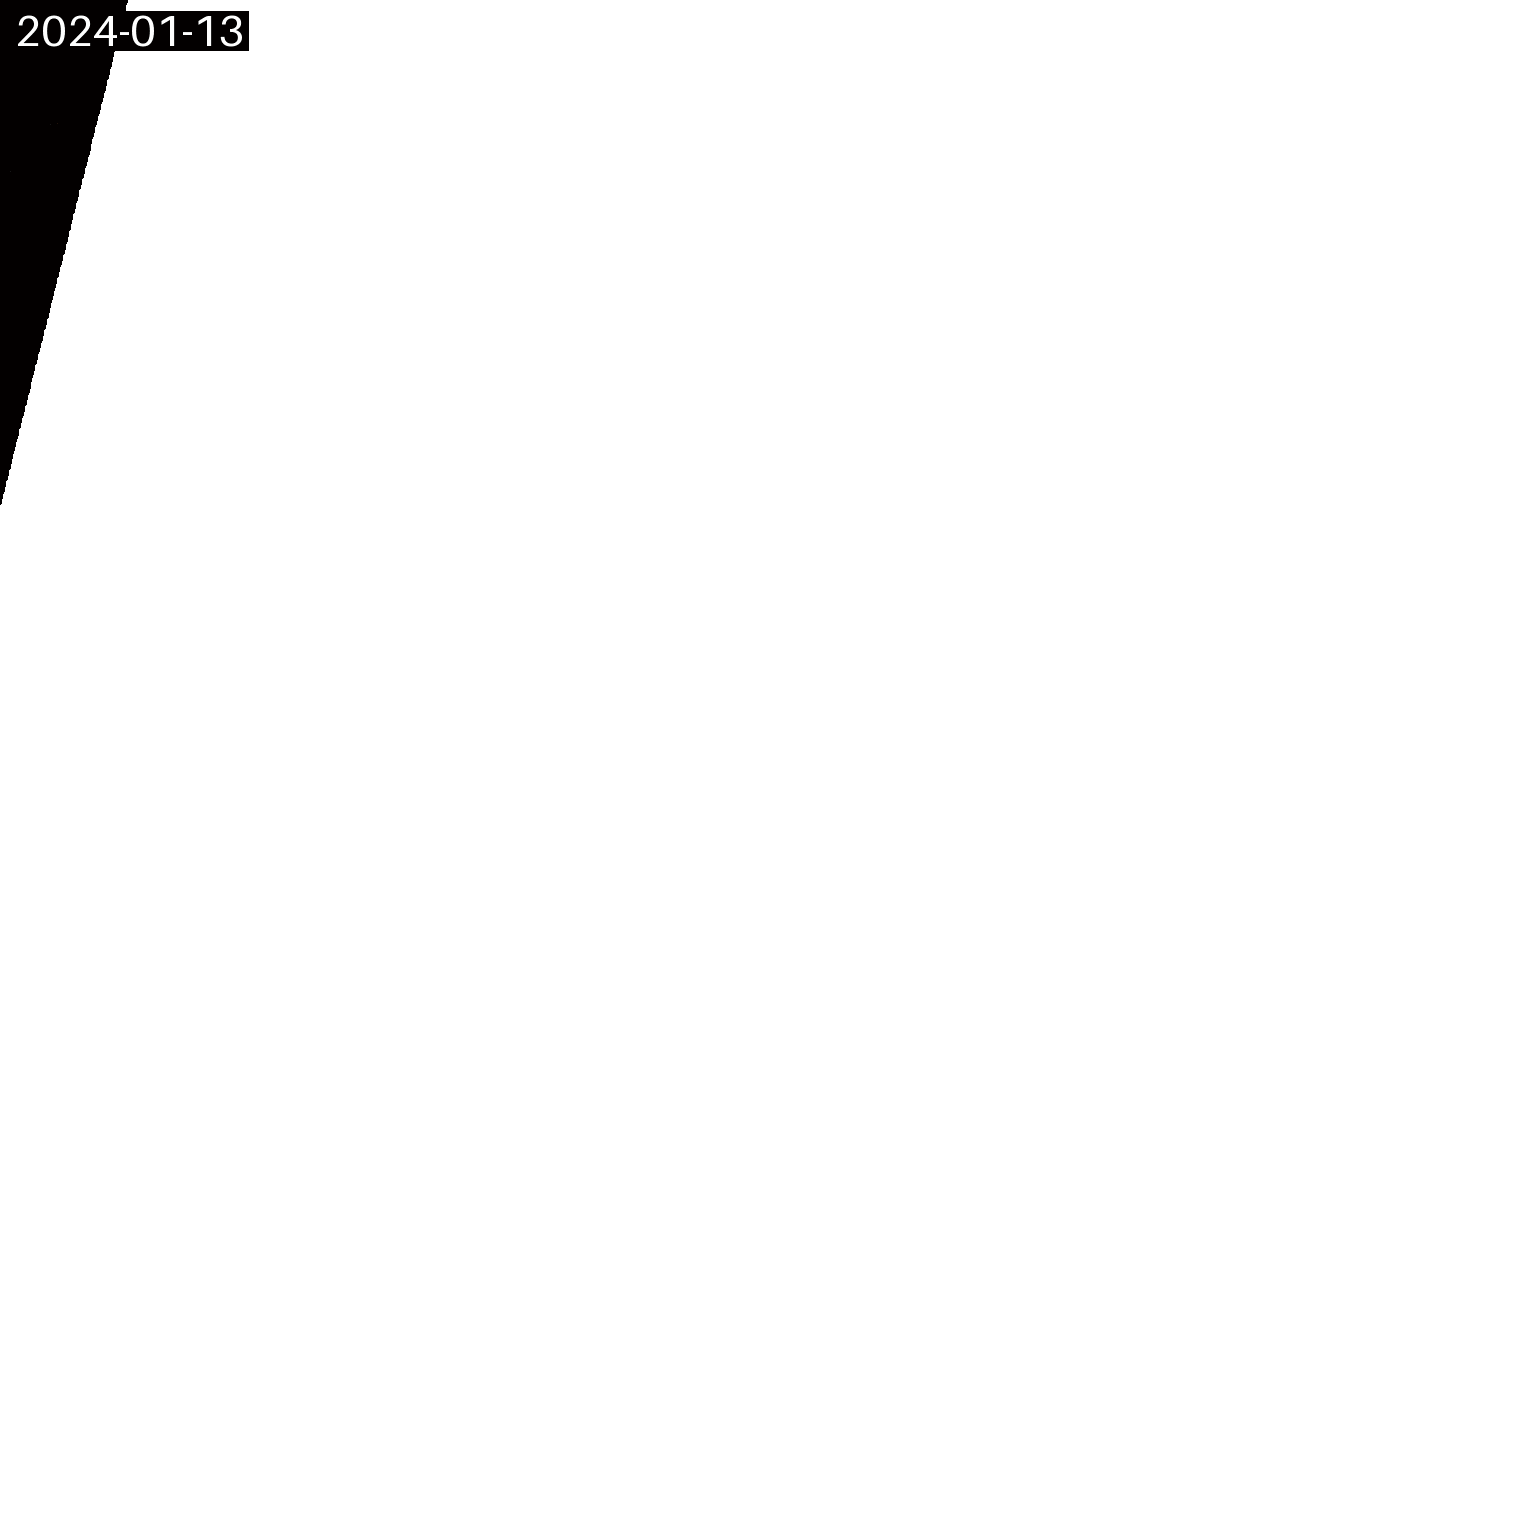

In [10]:
geogif.compute()

In [ ]:
# # Compute the 2nd and 98th percentiles for all data in rgb_composites
# global_min = rgb_composites.quantile(0.02).compute()
# global_max = rgb_composites.quantile(0.98).compute()

# # Plot with consistent vmin and vmax across all subplots using percentiles
# rgb_composites.plot.imshow(
#     col="time", 
#     rgb="band", 
#     col_wrap=5,
#     vmin=global_min,
#     vmax=global_max
# )

In [ ]:
# rgb_composites = rgb_composites.ffill("time").bfill("time")

# # Plot with consistent vmin and vmax across all subplots using percentiles
# rgb_composites.plot.imshow(
#     col="time", 
#     rgb="band", 
#     col_wrap=5,
#     vmin=global_min,
#     vmax=global_max
# )